This notebook is for Experiment 3: K-Means After PCA

The aims of this notebook is to achieve the following:

• Test with different numbers of principal components (2, 5, 10, 15, 20)

• Analyze trade-off between dimensionality and clustering quality

• Compare reconstruction error vs clustering performance

For ease of visualization and code readability, all codes previously made (K-Means and PCA) will be rewritten in the notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Load the breast cancer disgnostic dataset
dataset = load_breast_cancer()
features = dataset.data
target = dataset.target



In [ ]:
# Metrics:

def mse(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

def silhouette_score(X, labels):
  clusters = np.unique(labels)
  samples = X.shape[0]

  # Compute distances matrix
  distances = np.zeros((samples, samples))
  for i in range(samples):
    for j in range(samples):
      distances[i, j] = np.linalg.norm(X[i] - X[j])

  # Compute scores
  scores = np.zeros(samples)
  for i in range(samples):
    cluster = labels[i]
    # Cohesion
    same_samples = np.where(labels == cluster)[0]
    same_samples = same_samples[same_samples != i]

    if len(same_samples) == 0:
      cohesion = 0
    else:
      cohesion = np.mean(distances[i, same_samples])

    # Separation
    separation = np.inf
    for j in clusters:
      if j != cluster:
        separation_j = np.mean(distances[i, labels == j])
        if separation_j < separation:
          separation = separation_j

    scores[i] = (separation - cohesion) / max(separation, cohesion)

  return np.mean(scores)

def davies_bouldin_index(X, labels):
    clusters = np.unique(labels)
    samples = X.shape[0]

    centroids = []
    dispersion = []

    # Intra-Cluster
    for cluster in clusters:
        cluster_points = X[labels == cluster]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        dispersion.append(np.mean(np.linalg.norm(cluster_points - centroid, axis=1)))

    dispersion = np.array(dispersion)
    centroids = np.array(centroids)

    # Inter-Cluster
    distances = np.linalg.norm(centroids[:, np.newaxis] - centroids[np.newaxis, :], axis=2)

    max_ratios =[]
    for i in range(len(clusters)):
      current_index_ratio = []
      for j in range(len(clusters)):
        if i != j:
          ratio = (dispersion[i]+dispersion[j]) / distances[i, j]
          current_index_ratio.append(ratio)
      max_ratios.append(np.max(current_index_ratio))

    return np.mean(max_ratios)

def calinski_harabasz_index(X, labels):
  clusters = np.unique(labels)
  samples = X.shape[0]

  mean_global = np.mean(X, axis=0)

  # Between-Cluster Variance
  between_cluster_sum_of_squares = 0
  within_cluster_sum_of_squares = 0

  for cluster in clusters:
      cluster_points = X[labels == cluster]
      mean_cluster = np.mean(cluster_points, axis=0)

      nSamples = cluster_points.shape[0]
      within_cluster_sum_of_squares += np.sum((cluster_points - mean_cluster)**2)
      between_cluster_sum_of_squares += nSamples * np.sum((cluster_points - mean_global)**2)

  index = ((between_cluster_sum_of_squares / (len(clusters) - 1))) / (within_cluster_sum_of_squares / (samples - len(clusters)))

  return within_cluster_sum_of_squares, index

def adjusted_rand_index(labels_true, labels_pred):
  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in range(0, len(labels_pred)-1):
    for j in range(i+1, len(labels_pred)):
      if labels_pred[i] == labels_pred[j]:
        # Positive Pair
        if labels_true[i] == labels_true[j]:
          # True
          TP += 1
        else: #False
          FP += 1
      else: # Negative Pair
        if labels_true[i] == labels_true[j]:
          # False
          FN += 1
        else: # True
          TN += 1

  total_pairs = TP+TN+FP+FN

  expected_index = ((TP+FP)*(TP+FN))/total_pairs
  max_index = ((TP+FP)+(TP+FN))/2

  # Prevent division by zero

  if (max_index-expected_index) == 0:
    return 0.0

  ari = (TP-expected_index)/(max_index-expected_index)

  return ari

def normalized_mutual_information(labels_true, labels_pred):
  clusters = np.unique(labels_pred)
  classes = np.unique(labels_true)

  matrix = np.zeros((len(classes), len(clusters)))

  for i, c in enumerate(classes):
    for j, k in enumerate(clusters):
      matrix[i, j] = np.sum((labels_true == c) & (labels_pred == k))

  # Entropy calculation
  pi_true = np.sum(matrix,axis=1)/len(labels_true)
  pi_pred = np.sum(matrix,axis=0)/len(labels_pred)

  pi_true = pi_true[pi_true > 0]
  pi_pred = pi_pred[pi_pred > 0]

  h_true = -np.sum(pi_true * np.log2(pi_true))
  h_pred = -np.sum(pi_pred * np.log2(pi_pred))

  mutual_information = 0

  for i in range(len(classes)):
    for j in range(len(clusters)):
      if matrix[i, j] > 0:
        # Probability of point being in class i and cluster j
        p_ij = matrix[i, j] / len(labels_true)
        # Probability of point being in class i
        p_i  = np.sum(matrix[i, :]) / len(labels_true)
        # Probability of point being in cluster j
        p_j  = np.sum(matrix[:, j]) / len(labels_true)
        mutual_information += p_ij * np.log2(p_ij / (p_i * p_j))

  if (h_true + h_pred) == 0:
    return 0.0

  return 2* mutual_information / (h_true + h_pred)

def purity(labels_true, labels_pred):
  clusters = np.unique(labels_pred)
  classes = np.unique(labels_true)

  matrix = np.zeros((len(classes), len(clusters)))

  for i, c in enumerate(classes):
    for j, k in enumerate(clusters):
      matrix[i, j] = np.sum((labels_true == c) & (labels_pred == k))

  dominant_class = np.max(matrix, axis=0)
  return np.sum(dominant_class) / len(labels_true)



In [ ]:
# PCA Class From PCA Code

class PCA:
  def __init__(self, numberOfPrincipleComponents=2):
    self.numberOfPrincipleComponents = numberOfPrincipleComponents
    self.eigenvectors = None
    self.eigenvalues = None
    self.mean = None
    self.std = None
    self.covarianceMatrix = None
    self.explainedVarianceRatio = None
    self.pca = None
    self.reconstructed = None

  def fit(self, features):
    self.mean = np.mean(features, axis=0)
    self.std = np.std(features, axis=0)

    # Precautionary step to ensure no featurs having a standard deviation of zero do not halt the program.
    self.std[self.std == 0] = 1

    standardized = (features - self.mean) / self.std
    self.covarianceMatrix = np.cov(standardized.T)
    eigenvalues, eigenvectors = np.linalg.eig(self.covarianceMatrix)
    # By default, np.argsort sorts in ascending order. For this model, we need it to sort descendingly, thus the -1.
    sortedIndicies = np.argsort(eigenvalues)[::-1]
    self.eigenvalues = eigenvalues[sortedIndicies]
    # Sorts columns, not rows.
    self.eigenvectors = eigenvectors[:,sortedIndicies]

    totalVariance = np.sum(eigenvalues)
    self.explainedVarianceRatio = self.eigenvalues / totalVariance

    return self

  def project(self,features):
    standardized = (features - self.mean) / self.std
    # The np.dot function projects the input data onto the provided eigenvectors.
    pca = np.dot(standardized, self.eigenvectors[:, :self.numberOfPrincipleComponents])
    self.pca = pca
    return pca

  def reconstruct(self, projectedFeatures):
    # Reconstruct the data after projecting it on the prinicple axes:
    reconstructed = np.dot(projectedFeatures, self.eigenvectors[:, :self.numberOfPrincipleComponents].T) * self.std + self.mean
    self.reconstructed = reconstructed
    return reconstructed

  def reconstructionError(self, features):
    # Calculating the error in the reconstructed data
    projectedData = self.project(features)
    reconstructedData = self.reconstruct(projectedData)

    error = np.mean((features - reconstructedData)**2)

    print(f"Reconstruction Error using MSE:{error:.3f}")
    return error


  def plot(self,target):
    # Plotting a scatter plot
    plt.figure()
    color = ['r','g']
    names = ['Benign','Malignant']
    for i in range(len(color)):
      plt.scatter(self.pca[target==i,0], self.pca[target==i,1], c=color[i], label=names[i])
    plt.title("PCA Plot of Two Components")
    plt.xlabel(f"Principal Component 1 With Explained Variance of:{self.explainedVarianceRatio[0]:.3%}")
    plt.ylabel(f"Principal Component 2 With Explained Variance of:{self.explainedVarianceRatio[1]:.3%}")
    plt.legend()

    plt.figure()
    # Plot a bar chart for the explained variance of all features in the dataset
    barComponents=np.arange(1, len(self.explainedVarianceRatio)+1)
    plt.bar(barComponents, self.explainedVarianceRatio,align='center', label='Explained Variance of Each Feature')

    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principle Component Index')
    plt.title('Variance Ratio Plot')

In [ ]:
# K-Means Class From K-Means Code

class K_Means:
  def __init__(self, k=2, random_state=None):
    self.k = k
    self.random_state = random_state

  def kmeans_plusplus_init(self, X):
    if self.random_state is not None:
        np.random.seed(self.random_state)

    n_samples, n_features = X.shape
    centers = np.zeros((self.k, n_features))

    # Step 1: Choose first center randomly from data points
    first_center_idx = np.random.randint(0, n_samples)
    centers[0] = X[first_center_idx]
    print(f"Center 1 initialized at index {first_center_idx}")

    # Step 2: Choose remaining k-1 centers
    for i in range(1, self.k):
        # Calculate distance from each point to nearest existing center
        distances = np.zeros(n_samples)

        for j in range(n_samples):
            # Calculate distances to all existing centers
            dist_to_centers = np.zeros(i)
            for c in range(i):
                dist_to_centers[c] = np.sum((X[j] - centers[c]) ** 2)

            # Store minimum distance (squared distance to nearest center)
            distances[j] = np.min(dist_to_centers)

        # Choose next center with probability proportional to distance squared
        probabilities = distances / np.sum(distances)
        next_center_idx = np.random.choice(n_samples, p=probabilities)
        centers[i] = X[next_center_idx]
        print(f"Center {i+1} initialized at index {next_center_idx}")

    print(f"\nK-means++ initialization complete!")
    print(f"Initial centers shape: {centers.shape}")

    return centers

  def kmeans(self, X, k, centers, epochs, tolerance=1e-6):
    n_samples, n_features = X.shape
    labels = np.zeros(n_samples, dtype=int)
    inertia_history = []

    for epoch in range(epochs):
        # Step 1: Assignment - Assign each point to nearest center
        for i in range(n_samples):
            distances = np.zeros(k)
            for j in range(k):
                distances[j] = np.sum((X[i] - centers[j]) ** 2)
            labels[i] = np.argmin(distances)

        # Step 2: Update - Calculate new centers
        new_centers = np.zeros((k, n_features))
        for j in range(k):
            # Get all points assigned to cluster j
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = np.mean(cluster_points, axis=0)
            else:
                # If no points assigned, keep old center
                new_centers[j] = centers[j]

        # Calculate inertia (sum of squared distances to nearest center)
        inertia = 0
        for i in range(n_samples):
            inertia += np.sum((X[i] - centers[labels[i]]) ** 2)
        inertia_history.append(inertia)

        # Check for convergence
        center_shift = np.sum(np.abs(new_centers - centers))
        if center_shift < tolerance:
            print(f"\nConverged at epoch {epoch + 1}! (Center shift {center_shift:.6f} < tolerance {tolerance})")
            centers = new_centers
            break

        centers = new_centers
    print(f"Final inertia: {inertia_history[-1]:.4f}")

    # Print cluster sizes
    print(f"\nCluster sizes:")
    for i in range(k):
        cluster_size = np.sum(labels == i)
        print(f"Cluster {i}: {cluster_size} points")

    return centers, labels, inertia_history

In [ ]:
# Starting with experiment

def experiment(features, target, numberOfPrincipleComponents=[2,5,10,15,20]):

  results = {
      'dimensions':[], 'mse':[], 'silhouette':[], 'dbi':[], 'chi':[], 'purity':[], 'wcss':[], 'ari':[], 'explained_variance':[], 'nmi':[]
  }

  classes = len(np.unique(target))

  for n in numberOfPrincipleComponents:
    pca = PCA(n)
    pca.fit(features)
    reduced = pca.project(features)

    reconstructed = pca.reconstruct(reduced)
    mse_score = pca.reconstructionError(features)

    kmeans = K_Means(k=classes,random_state=42)
    initialCenters = kmeans.kmeans_plusplus_init(reduced)
    centers, labels, inertia_history = kmeans.kmeans(reduced, classes, initialCenters, epochs=100)

    sil = silhouette_score(reduced, labels)
    dbi = davies_bouldin_index(reduced, labels)
    wcss,chi = calinski_harabasz_index(reduced, labels)
    ari = adjusted_rand_index(target, labels)
    purity_score = purity(target, labels)
    nmi = normalized_mutual_information(target, labels)
    explainedVariance = np.sum(pca.explainedVarianceRatio[:n])

    results['dimensions'].append(n)
    results['mse'].append(mse_score)
    results['silhouette'].append(sil)
    results['dbi'].append(dbi)
    results['chi'].append(chi)
    results['purity'].append(purity_score)
    results['wcss'].append(wcss)
    results['ari'].append(ari)
    results['explained_variance'].append(explainedVariance)
    results['nmi'].append(nmi)

    print(f"\nCurrent Dimensions (Projected Data):{n}\n")
    print(f"MSE:{mse_score}\n")
    print(f"Silhouette Score:{sil}\n")
    print(f"Davies Bouldin Index:{dbi}\n")
    print(f"Calinski Harabasz Index:{chi}\n")
    print(f"Purity:{purity_score}\n")
    print(f"WCSS:{wcss}\n")
    print(f"ARI:{ari}\n")
    print(f"Explained Variance:{explainedVariance}\n")
    print(f"NMI:{nmi}\n")


    if n==2:
      print("\nConfusion Matrix\n")

      cm = confusion_matrix(target, labels)
      plt.figure()
      sb.heatmap(cm, annot=True, fmt='g',cbar=False,xticklabels=['Cluster 1', 'Cluster 0'], yticklabels=['Class 0', 'Class 1'])
      plt.xlabel('Predicted Cluster ID')
      plt.ylabel('True Label')
      plt.title('Confusion Matrix')
      plt.show()

      print("\n2D Projection and Variance Plot")
      pca.plot(target)
      plt.show()

  return results

def plotWCSS(results):
  plt.figure()
  plt.title("Elbow Curve")
  plt.xlabel("Number of dimensions")
  plt.ylabel("WCSS")
  plt.plot(results['dimensions'], results['wcss'], label='WCSS')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotInternal(results):
  plt.figure()
  plt.title("Internal Validation Metrics")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['silhouette'], label='Silhouette Score')
  plt.plot(results['dimensions'], results['dbi'], label='Davies Bouldin Index')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotCHI(results):
  plt.figure()
  plt.title("Calinski Harabasz Index")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['chi'], label='Calinski Harabasz Index')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotExternal(results):
  plt.figure()
  plt.title("External Validation Metrics")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['ari'], label='ARI')
  plt.plot(results['dimensions'], results['purity'], label='Purity')
  plt.plot(results['dimensions'], results['nmi'], label='NMI')
  plt.legend()
  plt.grid(True)
  plt.show()

def plotReconstructionError(results):
  plt.figure()
  plt.title("Reconstruction Error")
  plt.xlabel("Number of dimensions")
  plt.ylabel("Score")
  plt.plot(results['dimensions'], results['mse'], label='MSE')
  plt.legend()
  plt.grid(True)
  plt.show()


Experiment 3: K-Means After PCA

Reconstruction Error using MSE:809.793
Center 1 initialized at index 102
Center 2 initialized at index 430

K-means++ initialization complete!
Initial centers shape: (2, 2)

Converged at epoch 5! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 5332.5556

Cluster sizes:
Cluster 0: 378 points
Cluster 1: 191 points

Current Dimensions (Projected Data):2

MSE:809.7927504717508

Silhouette Score:0.5084690190672025

Davies Bouldin Index:0.8467403809951899

Calinski Harabasz Index:293705.1411818269

Purity:0.9068541300527241

WCSS:5332.555574203135

ARI:0.6592305570949524

Explained Variance:0.6324320765155946

NMI:0.5403814627831337


Confusion Matrix



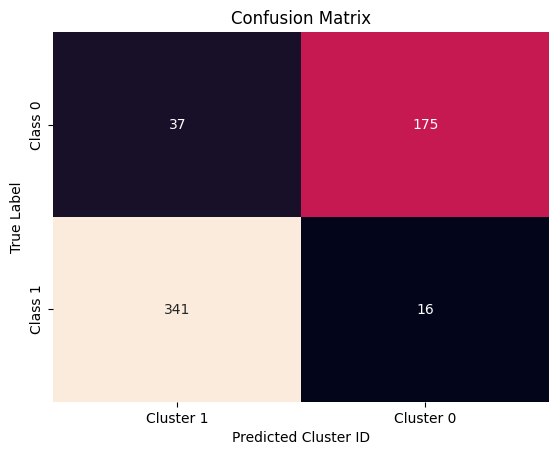


2D Projection and Variance Plot


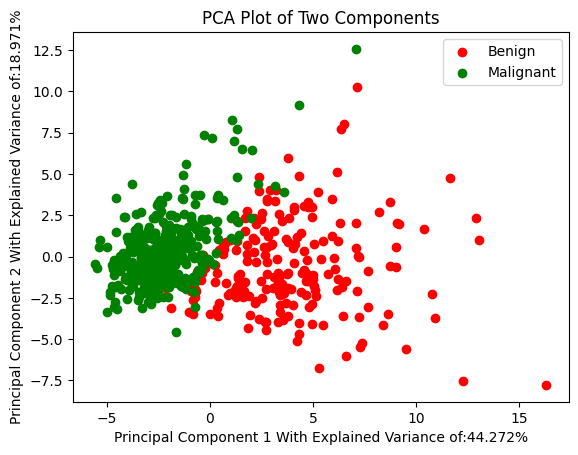

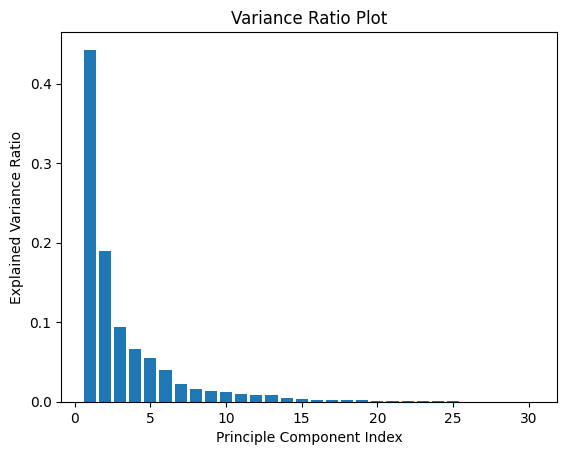

Reconstruction Error using MSE:729.817
Center 1 initialized at index 102
Center 2 initialized at index 430

K-means++ initialization complete!
Initial centers shape: (2, 5)

Converged at epoch 7! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 8992.1305

Cluster sizes:
Cluster 0: 375 points
Cluster 1: 194 points

Current Dimensions (Projected Data):5

MSE:729.8173415293901

Silhouette Score:0.3918571464102746

Davies Bouldin Index:1.1489013654222102

Calinski Harabasz Index:241018.71792267804

Purity:0.9050966608084359

WCSS:8992.130462630234

ARI:0.6536246043910179

Explained Variance:0.8473427431680726

NMI:0.5324078598532429

Reconstruction Error using MSE:515.558
Center 1 initialized at index 102
Center 2 initialized at index 432

K-means++ initialization complete!
Initial centers shape: (2, 10)

Converged at epoch 4! (Center shift 0.000000 < tolerance 1e-06)
Final inertia: 10770.5470

Cluster sizes:
Cluster 0: 375 points
Cluster 1: 194 points

Current Dimensions (Projecte

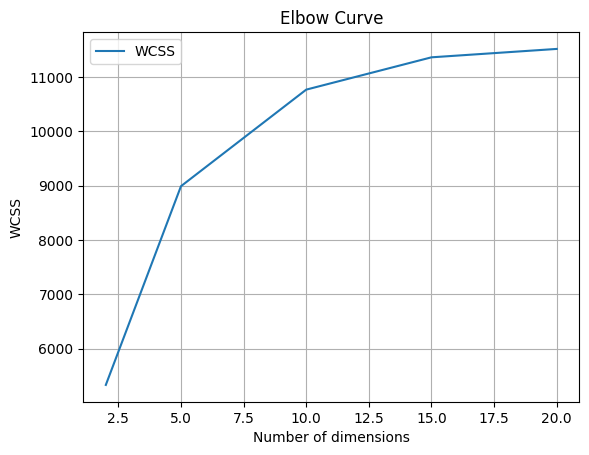

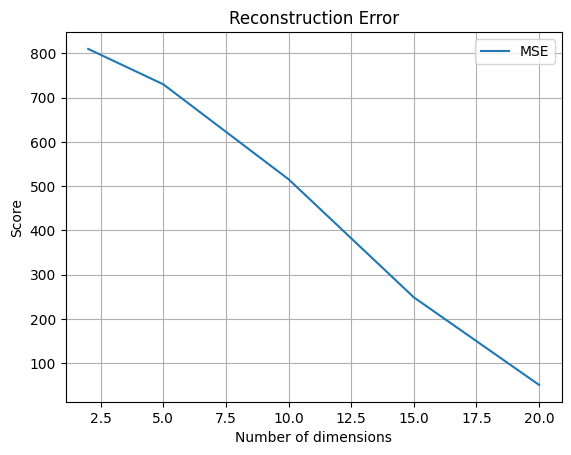

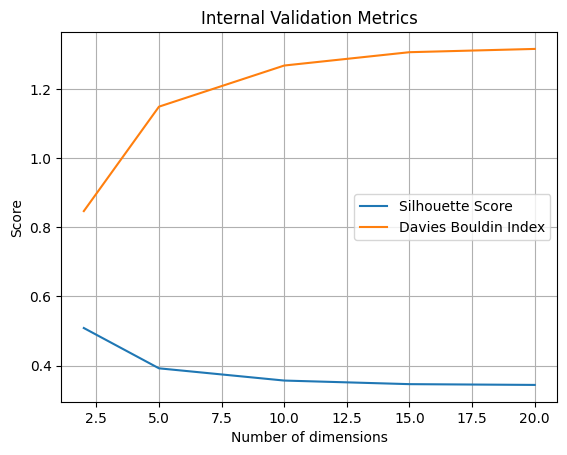

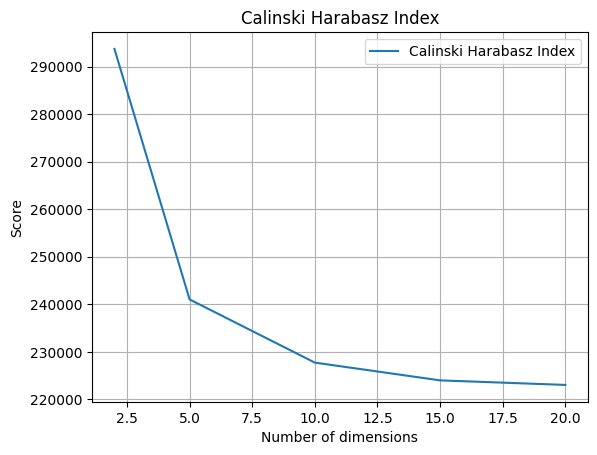

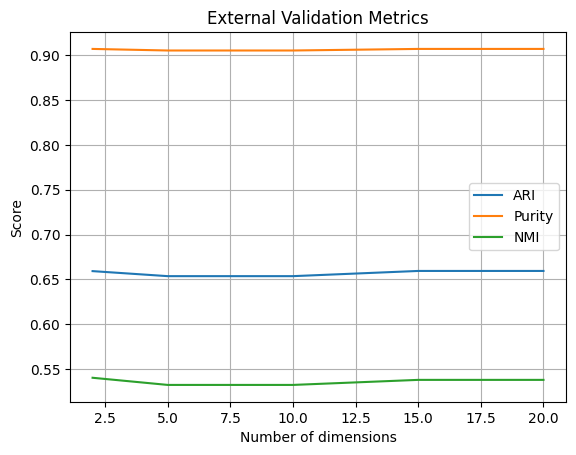

In [ ]:
print("Experiment 3: K-Means After PCA\n")
results = experiment(features, target, numberOfPrincipleComponents=[2,5,10,15,20])

print("\nVisulization\n")
plotWCSS(results)
plotReconstructionError(results)

plotInternal(results)
plotCHI(results)
plotExternal(results)

The Curse of Dimensionality

The data was seen to be highly dependent on a number of features. This lead the reduction in dimensions to lead to fascinating results when combined with the K-Means Algorithm.

The results prove that using two dimensions is the most optimal number of dimensions to be chosen. The silhouette score was 0.508 when the number of dimensions chosen was 2, and eventually dropped down to 0.344 when they increased to 20. Adding more dimensions introduced noise to the features, increasing the distances between points of the same cluster and degrading the density of each cluster.

As would be expected, the reconstruction error significantly decreases as the number of dimensions increase (809.8 to 51.4) yet the adjusted rand index did not change and was almost 0.6. This goes on to show that the first two components were helpful in identifying almost 60% of the variance in the data and was a 100% useful for clustering. Any increase in dimensions did not yield significant results for the separation between the two clusters.